In [2]:
%matplotlib inline

import os
import math
import copy

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import torch
import torchvision

# import skimage
from skimage.io import imread

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

**Configurations**

In [3]:
EPOCHS = 5
USE_GPU = True

**Load labels**

In [6]:
labels_df = pd.read_csv("../input/train_labels.csv")

In [7]:
labels_df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


**Make sure we are not having the imbalanced classification problem**

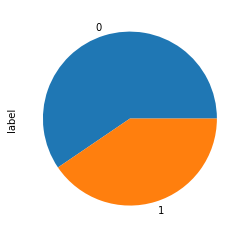

In [8]:
labels_df["label"].value_counts().plot(kind="pie")

**Train test split for model selection**

In [9]:
train_indices, test_indices = train_test_split(labels_df.index, test_size=0.25)

In [10]:
train_indices.shape, test_indices.shape

((165018,), (55007,))

In [11]:
class HistopathologicCancerDataset(torch.utils.data.Dataset):
    """
    This is our custom dataset class which will load the images, perform transforms on them,
    and load their corresponding labels.
    """
    
    def __init__(self, img_dir, labels_csv_file=None, transform=None):
        self.img_dir = img_dir
        
        if labels_csv_file:
            self.labels_df = pd.read_csv(labels_csv_file)
        else:
            self.images = [os.path.join(img_dir, f) for f in os.listdir(img_dir) if f.endswith(".tif")]
            
        self.transform = transform
        
    def __getitem__(self, idx):
        try:
            img_path = os.path.join(
                self.img_dir,
                "{}.tif".format(self.labels_df.iloc[idx, 0])
            )
        except AttributeError:
            img_path = self.images[idx]

#         print("img_path:", img_path)
        img = imread(img_path)
        
        if self.transform:
            img = self.transform(img)
        
        sample = {
            "image": img,
        }
        try:
            sample["label"] = self.labels_df.loc[idx, "label"]
            sample["id"] = self.labels_df.loc[idx, "id"]
        except AttributeError:
            sample["id"] = os.path.basename(self.images[idx]).replace(".tif", "")
        
        return sample
    
    def __len__(self):
        try:
            return self.labels_df.shape[0]
        except AttributeError:
            return len(self.images)

**Image tranformation pipeline**

In [12]:
transform_pipe = torchvision.transforms.Compose([
    torchvision.transforms.ToPILImage(), # Convert np array to PILImage
    
    # Resize image to 224 x 224 as required by most vision models
    torchvision.transforms.Resize(
        size=(224, 224)
    ),
    
    # Convert PIL image to tensor with image values in [0, 1]
    torchvision.transforms.ToTensor(),
    
    torchvision.transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [13]:
train_data = HistopathologicCancerDataset(
    img_dir="../input/train/",
    labels_csv_file="../input/train_labels.csv",
    transform=transform_pipe
)

**The training dataset loader will randomly sample from the train samples**

In [14]:
train_loader = torch.utils.data.DataLoader(
    train_data,
    batch_size=64,
    sampler=torch.utils.data.SubsetRandomSampler(
        train_indices
    )
#     shuffle=True,
#     num_workers=8
)

**The training dataset loader will randomly sample from the test samples**

In [15]:
test_loader = torch.utils.data.DataLoader(
    train_data,
    batch_size=64,
    sampler=torch.utils.data.SubsetRandomSampler(
        test_indices
    )
#     shuffle=True,
#     num_workers=8
)

In [16]:
dataloaders = {
    "train": train_loader,
    "test": test_loader
}

In [17]:
class Flatten(torch.nn.Module):
    """
    Custom flatten module like what is available in Keras.
    """
    
    def forward(self, input):
        return input.view(input.size(0), -1)

**Model definition**

In [18]:
# model = torch.nn.Sequential(
#     torch.nn.Conv2d(
#         in_channels=3,
#         out_channels=8,
#         kernel_size=3,
#     ),
#     torch.nn.MaxPool2d(
#         kernel_size=2
#     ),
#     torch.nn.ReLU(),
    
#     torch.nn.Conv2d(
#         in_channels=8,
#         out_channels=16,
#         kernel_size=3
#     ),
#     torch.nn.MaxPool2d(
#         kernel_size=2
#     ),
#     torch.nn.ReLU(),
    
#     torch.nn.Conv2d(
#         in_channels=16,
#         out_channels=32,
#         kernel_size=3
#     ),
#     torch.nn.MaxPool2d(
#         kernel_size=2
#     ),
#     torch.nn.ReLU(),
    
#     torch.nn.Conv2d(
#         in_channels=32,
#         out_channels=64,
#         kernel_size=3
#     ),
#     torch.nn.MaxPool2d(
#         kernel_size=2
#     ),
#     torch.nn.ReLU(),
    
#     Flatten(),
    
#     torch.nn.Linear(
#         in_features=1024,
#         out_features=1
#     ),
#     torch.nn.Sigmoid()
# )

In [19]:
# model = torchvision.models.resnet50(pretrained=True)
model = torchvision.models.resnet50()

In [20]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

**Replace the final fully connected layer to suite the problem**

In [21]:
model.fc = torch.nn.Sequential(
    torch.nn.Linear(
        in_features=2048,
        out_features=1
    ),
    torch.nn.Sigmoid()
)

In [22]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [23]:
# out = model(train_data[0]["image"].view(1, 3, 224, 224))

In [24]:
# out.shape

In [25]:
# Some utils functions.
# Seems like PyTorch does not auto-infer tensor shapes in a sequential model, so we need to figure the shapes ourself.

def compute_conv2d_output_dimensions(Hin, Win, kernel_size, padding=(0, 0), dilation=(1, 1), stride=(1, 1)):
    Hout = math.floor(((Hin + 2 * padding[0] - dilation[0] * (kernel_size[0] - 1) - 1) / stride[0]) + 1)
    Wout = math.floor(((Win + 2 * padding[1] - dilation[1] * (kernel_size[1] - 1) - 1) / stride[1]) + 1)
    return Hout, Wout


def compute_maxpooling2d_output_dimensions(Hin, Win, kernel_size, stride=None, padding=(0, 0), dilation=(1, 1)):
    if stride is None:
        stride = kernel_size
    
    Hout = math.floor(((Hin + 2 * padding[0] - dilation[0] * (kernel_size[0] - 1) - 1) / stride[0]) + 1)
    Wout = math.floor(((Win + 2 * padding[1] - dilation[1] * (kernel_size[1] - 1) - 1) / stride[1]) + 1)
    return Hout, Wout

In [26]:
# compute_conv2d_output_dimensions(96, 96, (3, 3))

In [27]:
# compute_maxpooling2d_output_dimensions(94, 94, kernel_size=(2, 2))

**Model training**

In [28]:
if USE_GPU:
    model = model.cuda() # Should be called before instantiating optimizer according to docs: https://pytorch.org/docs/stable/nn.html

optimizer = torch.optim.Adam(model.parameters())
criterion = torch.nn.BCELoss()

best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0

for i in range(EPOCHS):
    for phase in ["train", "test"]:
        if phase == "train":
            model.train()
        else:
            model.eval()
        
        samples = 0
        loss_sum = 0
        correct_sum = 0
        for j, batch in enumerate(dataloaders[phase]):
            X = batch["image"]
            labels = batch["label"]
            if USE_GPU:
                X = X.cuda()
                labels = labels.cuda()

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                y = model(X)
                loss = criterion(
                    y, 
                    labels.view(-1, 1).float()
                )

                if phase == "train":
                    loss.backward()
                    optimizer.step()
                    
                loss_sum += loss.item() * X.shape[0] # We need to multiple by batch size as loss is the mean loss of the samples in the batch
                samples += X.shape[0]
                num_corrects = torch.sum((y >= 0.5).float() == labels.view(-1, 1).float())
                correct_sum += num_corrects
                
                # Print batch statistics every 50 batches
                if j % 50 == 49 and phase == "train":
                    print("{}:{} - loss: {}, acc: {}".format(
                        i + 1, 
                        j + 1, 
                        float(loss_sum) / float(samples), 
                        float(correct_sum) / float(samples)
                    ))
                
        # Print epoch statistics
        epoch_acc = float(correct_sum) / float(samples)
        epoch_loss = float(loss_sum) / float(samples)
        print("epoch: {} - {} loss: {}, {} acc: {}".format(i + 1, phase, epoch_loss, phase, epoch_acc))
        
        # Deep copy the model
        if phase == "test" and epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(best_model_wts, "resnet50.pth")

1:50 - loss: 0.5541956335306167, acc: 0.765
1:100 - loss: 0.49443925768136976, acc: 0.79078125
1:150 - loss: 0.4721097391843796, acc: 0.7969791666666667
1:200 - loss: 0.4612411677837372, acc: 0.799765625
1:250 - loss: 0.4511895268559456, acc: 0.8039375
1:300 - loss: 0.4417624652882417, acc: 0.8080729166666667
1:350 - loss: 0.43339496059077126, acc: 0.8121428571428572
1:400 - loss: 0.4278258030116558, acc: 0.8143359375
1:450 - loss: 0.4225678190920088, acc: 0.8161458333333333
1:500 - loss: 0.4168673585653305, acc: 0.818375
1:550 - loss: 0.41478787657889454, acc: 0.819659090909091
1:600 - loss: 0.41190163634717464, acc: 0.82140625
1:650 - loss: 0.40719664635566566, acc: 0.8233894230769231
1:700 - loss: 0.4044973518167223, acc: 0.8250669642857142
1:750 - loss: 0.40180455243587493, acc: 0.8265
1:800 - loss: 0.39831269735470415, acc: 0.82828125
1:850 - loss: 0.3966407494860537, acc: 0.8293014705882353
1:900 - loss: 0.3936824873420927, acc: 0.8305902777777778
1:950 - loss: 0.3913485365008053

3:2000 - loss: 0.19026232855953276, acc: 0.927421875
3:2050 - loss: 0.19035640619331742, acc: 0.927454268292683
3:2100 - loss: 0.19028847430788334, acc: 0.9275372023809524
3:2150 - loss: 0.19010179292323978, acc: 0.9276308139534883
3:2200 - loss: 0.18987586038356477, acc: 0.9276775568181819
3:2250 - loss: 0.18956715349025197, acc: 0.9277291666666667
3:2300 - loss: 0.18957754661855492, acc: 0.9276970108695652
3:2350 - loss: 0.18969646343842467, acc: 0.9276462765957447
3:2400 - loss: 0.18945383802366753, acc: 0.9278059895833334
3:2450 - loss: 0.18952480147383652, acc: 0.9277806122448979
3:2500 - loss: 0.18955277830958367, acc: 0.92778125
3:2550 - loss: 0.1894035215500523, acc: 0.9278860294117647
epoch: 3 - train loss: 0.18936319791370115, train acc: 0.927959374128883
epoch: 3 - test loss: 0.17596655296648062, test acc: 0.9319359354264003
4:50 - loss: 0.213369060754776, acc: 0.916875
4:100 - loss: 0.19105197995901108, acc: 0.92640625
4:150 - loss: 0.18192161671817303, acc: 0.9296875
4:200

**Persist latest model**

In [29]:
# torch.save(best_model_wts, "resnet50.pth")

**Reconstruct model from saved weights**

In [30]:
model1 = torchvision.models.resnet50()
model1.fc = torch.nn.Sequential(
    torch.nn.Linear(
        in_features=2048,
        out_features=1
    ),
    torch.nn.Sigmoid()
)
model1.load_state_dict(torch.load("resnet50.pth"))

**Make predictions**

In [31]:
test_data = HistopathologicCancerDataset(
    img_dir="../input/test/",
    transform=transform_pipe
)

In [32]:
test_loader1 = torch.utils.data.DataLoader(
    test_data,
    batch_size=64,
#     shuffle=True,
#     num_workers=8
)

In [33]:
model1.eval()
if USE_GPU:
    model1 = model1.cuda()

ids_all = []
predictions = []

for j, batch in enumerate(test_loader1):
    X = batch["image"]
    ids = batch["id"]
    if USE_GPU:
        X = X.cuda()
    
    for _id in ids:
        ids_all.append(_id)

    with torch.set_grad_enabled(False):
        y_pred = model1(X)
        predictions.append((y_pred >= 0.5).float().cpu().numpy())
        
print("Done making predictions!")

Done making predictions!


In [34]:
submissions = pd.DataFrame({
    "id": ids_all,
    "label": np.concatenate(predictions).reshape(-1,).astype("int")
}).set_index("id")

In [35]:
submissions.head()

,label
id,
e9d30682a1d9577d1e392258f0f2a8d8b966ab13,0
70ab2d5e46e5b8983664488534af80ed500d501c,0
4cb23f986fffdc7b76430f1d1dc0108f902dee03,1
b0923ef9407bd47f6027a6b620e877fc67402da9,0
50c513de531389f9631afbc25dfa037fd7c91547,1


In [36]:
submissions.to_csv("submissions.csv")